# Download the data to begin processing steps

In [ ]:
import pandas as pd
import polars as pl

df = pd.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet")
df_pl = pl.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet")

# There are a lot of partially or fully empty columns in each parquet so we need to identify these as the first step of preprocessing

In [ ]:
# Three Cases
# 1. Fully Empty columns : we can just drop them
# 2. Partially Empty Columns: we can impute them
# 3. Full Columns : No imputation necessary

empty_columns = []
fully_filled_columns = []
partially_empty_columns = []

for feature in df_pl.columns:
    # Count empty and non-empty rows
    empty_rows = df_pl[feature].is_null().sum()
    nonempty_rows = len(df_pl[feature]) - empty_rows

    # Classify the columns based on the counts
    if nonempty_rows == 0:
        empty_columns.append(feature)
    elif empty_rows == 0:
        fully_filled_columns.append(feature)
    else:
        partially_empty_columns.append(feature)

# We don't use df_pl again, so delete it to conserve memory
del df_pl

# Next we drop the empty columns, sort the values by time, fill columns which are partially empty, and organize the columns into different groupings.

In [ ]:
# drop empty columns using imputer
df = df.drop(empty_columns, axis = 1)

# Fill in partially empty columns
for feature in partially_empty_columns:
    df[feature] = df.groupby('symbol_id')[feature].transform(lambda x: x.ffill().bfill())

# Split data temporally - in partition0 there are 170 days and 849 unique time ids per day
df = df.sort_values(['date_id', 'time_id'])
date_counts = df.date_id.value_counts()
date_counts = pd.DataFrame(date_counts.sort_index())
date_counts['cumulative_sum'] = date_counts['count'].cumsum()

# Organize columns into different groups
TIME_FEATURES = ['relative_timestamp']
MARKET_FEATURES = [f'feature_{i:02}' for i in range(0,79) if f'feature_{i:02}' in df.columns]
RESPONDER_FEATURES = [f'responder_{i}' for i in range(0,9) if f'responder_{i}' in df.columns]
SYMBOL_FEATURES = ['symbol_id']

# Normalize all the responders and feature using standard scaler. This is a little dicey because we don't know whether or not the features are already normalized, but this is a risk we are willing to take.

In [ ]:
# Normalize Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols_to_normalize = MARKET_FEATURES + RESPONDER_FEATURES
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# Split the data into train, validation, and testing sets. Also encode symbol_id so that it can be used as categorial data.
We are using the time index instead of train-test-split. We need to do this because train-test-split will choose random values which will cause our model to improperly train and overfit. This is because it is time-series data, so if we pick testing points in between the training points, these values will be much easier to predict since the model has seen the surrounding values. Our train, val, and test percentages are 60%, 20%, and 20% respectively. Additionally, before splitting into the sets and we encode the symbol_id using one-hot-encoder so that they are processed as categorical features instead of numerical features.

In [ ]:
# Determine splitting points
total = len(df)
train_percentage = 0.6
val_percentage = 0.2
test_percentage = 0.2
apprx_train_len = int(total*train_percentage)
apprx_val_len = int(total*val_percentage) 
apprx_test_len = total - apprx_train_len - apprx_val_len

# Determine Splitting points
def split_func(row):
    s = row['cumulative_sum']
    if s <= apprx_train_len:
        return 'Train'
    elif (s > apprx_train_len) and (s <= apprx_train_len + apprx_val_len):
        return 'Val'
    elif (s > apprx_train_len + apprx_val_len):
        return 'Test'
    else:
        raise ValueError

date_counts['Split'] = date_counts.apply(split_func, axis = 1)
last_train_data = date_counts[date_counts.Split == 'Train'].tail(1) 
first_test_data = date_counts[date_counts.Split == 'Test'].head(1)

# Once Splitting points are determined, then make the necessary splits
def split_func_df(row):
    s = row['date_id']
    if s <= last_train_data.index[0]:
        return 'Train'
    elif (s > last_train_data.index[0]) and (s < first_test_data.index[0]):
        return 'Val'
    elif (s >= first_test_data.index[0]):
        return 'Test'
    else:
        raise ValueError

# Encode the symbol_id using one-hot-encoder so that they are processed as categorical features instead of numerical features
df = df[df.symbol_id.isin(range(10))]
encoded = pd.get_dummies(df['symbol_id'], prefix='symbol_id')
max_symbol_id = df['symbol_id'].max()
encoded.head()
df = pd.concat([df, encoded], axis = 1)
df = df.drop(['symbol_id'], axis = 1)

df['Split'] = df.apply(split_func_df, axis = 1)
df['Split'].value_counts()

train_df = df[df.Split == 'Train']
val_df = df[df.Split == 'Val']
test_df = df[df.Split == 'Test']

# Now that preprocessing is done, we can start implementing our models. First we apply XGboost.
XGboost is used to create additional features for predicting the value of responder_6. We do this because XGboost is not strictly a time-series model so it is able to capture different aspects of the dataset than the LSTM model. XGboost is able to capture non-temporal relationships and provide a prediction for responder_6 that can help the LSTM model come to a better conclusion of the actual value of responder_6. We use squarederror as the XGboost objective since we are trying to predict a numerical value. The number of gradient-boosting trees is set by n_estimators, and we use a value of 100. This number is the default value, and we achieved good results so we did not tune it further. Better tuning of the XGboost model is definitely possible.

In [3]:
import xgboost as xgb

# General Feature set (used for training LSTM)
features = ['date_id', 'time_id', 'feature_06', 'feature_07', 'feature_05', 'feature_68', 'responder_6']+list(encoded.columns)
# Define features for XGBoost (does not include responder_6 so that we can train XGboost)
xgb_features = ['date_id', 'time_id', 'feature_06', 'feature_07', 'feature_05', 'feature_68'] + list(encoded.columns)

# Train XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(train_df[xgb_features], train_df['responder_6'])

# Make predictions
train_df['xgb_pred'] = xgb_model.predict(train_df[xgb_features])
val_df['xgb_pred'] = xgb_model.predict(val_df[xgb_features])


/tmp/ipykernel_23/3299139115.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['xgb_pred'] = xgb_model.predict(train_df[xgb_features])
/tmp/ipykernel_23/3299139115.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['xgb_pred'] = xgb_model.predict(val_df[xgb_features])


# Now that we have all the features that we would like to use, we can train the Long Short Term Memory (LSTM) neural network model. 
For training, we are using the top-4 features and the additional prediction from the XGboost model. We use the top-4 features because this makes it possible to train the model given the limited Kaggle resources. These features were chosen using a correlation matrix which is detailed in the VAR notebook. A future implementation could use PCA instead of just choosing these K-features. Note, that unlike a VAR model,the time-series data is left as distinct dates and times instead of combining them into one index.

## The first step for implementing a neural network is to split the training and validation data into sequeunces of a fixed length. 
For this training, we are using an arbitrary sequence length of 50, but there is potential that this could be tweaked for better results.

In [ ]:
import numpy as np
features_with_xgb = features + ['xgb_pred']

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data['responder_6'].iloc[i+sequence_length]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# Create sequences
X_train, y_train = create_sequences(train_df[features_with_xgb], sequence_length=50)
X_val, y_val = create_sequences(val_df[features_with_xgb], sequence_length=50)

## The next step is to define the model.
For this case, we found that implementing two LSTM layers and one dense layer (necessary for regression) produced good results, but other combinations are definitely possible. Using "tanh" as the activation function yielded fair results, and in our testing, ReLu actually performed worse overall both in terms of accuracy and also the drastic increase in train time per epoch. We used Additionally, we also added optimizations that allow for the tensor processing cores on a TPU or specific GPUs (like the Nvidia T4) can be used to speed up the training process. We started out training with 5 epochs, and add further training later.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import TensorBoard

# Primary function of these two lines is to enable optimization using tensor cores
set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

# Define the model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Create TensorFlow datasets to optimize for running on Nvidia T4s
batch_size = 128
train_data = tf.data.Dataset.from_tensor_slices((X_train.astype('float'), y_train.astype('float'))).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val.astype('float'), y_val.astype('float'))).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# TensorBoard callback with profiling
tensorboard_cb = TensorBoard(log_dir="./logs", profile_batch='2,10')

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    callbacks=[tensorboard_cb]
)

## The following sections are just training the model with more epochs to get the desired results.

In [5]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    verbose=1,
    callbacks=[tensorboard_cb]
)

Epoch 1/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.5094 - mae: 0.4777 - val_loss: 0.5529 - val_mae: 0.5129
Epoch 2/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.4696 - mae: 0.4592 - val_loss: 0.5404 - val_mae: 0.5072
Epoch 3/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.4312 - mae: 0.4391 - val_loss: 0.5045 - val_mae: 0.4925
Epoch 4/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.3961 - mae: 0.4210 - val_loss: 0.4925 - val_mae: 0.4840
Epoch 5/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.3616 - mae: 0.4037 - val_loss: 0.4642 - val_mae: 0.4734


In [6]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    verbose=1,
    callbacks=[tensorboard_cb]
)

Epoch 1/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.3164 - mae: 0.3783 - val_loss: 0.4191 - val_mae: 0.4507
Epoch 2/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.2839 - mae: 0.3586 - val_loss: 0.3924 - val_mae: 0.4296
Epoch 3/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.2761 - mae: 0.3553 - val_loss: 0.3833 - val_mae: 0.4248
Epoch 4/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.2610 - mae: 0.3457 - val_loss: 0.3557 - val_mae: 0.4044
Epoch 5/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.2750 - mae: 0.3536 - val_loss: 0.3412 - val_mae: 0.3936


In [7]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    verbose=1,
    callbacks=[tensorboard_cb]
)

Epoch 1/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.2721 - mae: 0.3521 - val_loss: 0.3058 - val_mae: 0.3634
Epoch 2/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.2486 - mae: 0.3333 - val_loss: 0.3173 - val_mae: 0.3836
Epoch 3/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.2595 - mae: 0.3402 - val_loss: 0.2871 - val_mae: 0.3581
Epoch 4/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.2395 - mae: 0.3273 - val_loss: 0.2941 - val_mae: 0.3620
Epoch 5/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.2281 - mae: 0.3196 - val_loss: 0.2796 - val_mae: 0.3470


In [8]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    verbose=1,
    callbacks=[tensorboard_cb]
)

Epoch 1/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.2511 - mae: 0.3364 - val_loss: 0.2706 - val_mae: 0.3398
Epoch 2/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.2442 - mae: 0.3344 - val_loss: 0.2718 - val_mae: 0.3334
Epoch 3/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.2325 - mae: 0.3218 - val_loss: 0.2636 - val_mae: 0.3334
Epoch 4/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.2373 - mae: 0.3252 - val_loss: 0.2538 - val_mae: 0.3255
Epoch 5/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.2348 - mae: 0.3250 - val_loss: 0.2773 - val_mae: 0.3444


In [9]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    verbose=1,
    callbacks=[tensorboard_cb]
)

Epoch 1/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.2472 - mae: 0.3350 - val_loss: 0.2628 - val_mae: 0.3287
Epoch 2/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.2311 - mae: 0.3220 - val_loss: 0.2837 - val_mae: 0.3492
Epoch 3/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.2312 - mae: 0.3221 - val_loss: 0.2739 - val_mae: 0.3411
Epoch 4/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.2305 - mae: 0.3175 - val_loss: 0.2558 - val_mae: 0.3274
Epoch 5/5
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.2785 - mae: 0.3540 - val_loss: 0.2675 - val_mae: 0.3360


## At this point the validation loss and training loss are not reducing further and are fairly close in value, so I think it is not worth continuing to train on more epochs. Let's save the model for future use.

In [15]:
model.save('model.h5')

## Next create the testing sequences so we can test the model on fresh data.

In [16]:
X_test, y_test = create_sequences(test_df[features], sequence_length=50)

test_data = tf.data.Dataset.from_tensor_slices((X_test.astype('float'), y_test.astype('float'))).batch(batch_size).prefetch(tf.data.AUTOTUNE)

result = model.evaluate(test_data)

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3389 - mae: 0.8060


This loss is much higher than the training set indicating that the model is overfitting by a fair margin and more tuning is required.

In [17]:
s_0 = test_df[test_df.symbol_id_0 == 1]

len(s_0)

sample_df = s_0.iloc[::100]

print(len(sample_df))

221


In [18]:
X_s, y_s = create_sequences(sample_df[features], sequence_length=50)

sample_data = tf.data.Dataset.from_tensor_slices((X_s.astype('float'))).batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Finally plot the results of the running the model with the test set.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


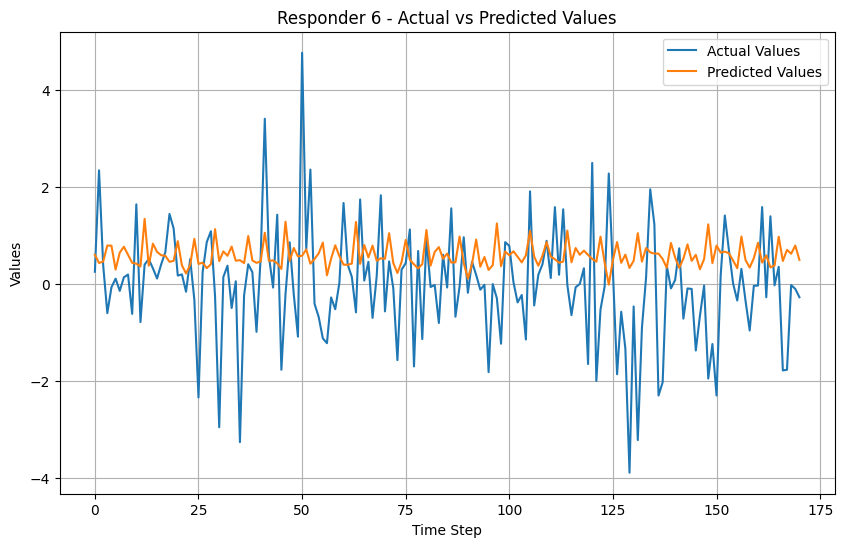

In [19]:
import matplotlib.pyplot as plt



# Get the data for responder_6 in the test set

responder_6_predictions = model.predict(sample_data)

responder_6_actual_values = y_s

# Plot the actual vs predicted values

plt.figure(figsize=(10, 6))  # Adjust figure size as needed 

plt.plot(range(len(responder_6_actual_values)), responder_6_actual_values, label='Actual Values')

plt.plot(range(len(responder_6_predictions.squeeze())), responder_6_predictions.squeeze(), label='Predicted Values')  # Squeeze to remove extra dimension

plt.xlabel('Time Step')

plt.ylabel('Values')

plt.title(f'Responder 6 - Actual vs Predicted Values')

plt.legend()

plt.grid(True)

plt.show()

## Conclusions
I think the difference between the results from the train/val and the test set can be explained by the fact that the test set is completely new data to the model that has little resemblance to the data that it was trained on. To improve this relationship, one could potentially implement better tuning on both the XGboost and LSTM model to reduce overfitting and increase the correlation between the features and responders. Overall, I think these results are acceptable for the time being.